In [1]:
#from pioran import PSDToACV
#from pioran.psd import OneBendPowerLaw


from THESIS import LightCurveSampler, JAXNSmodelCreator, ModelComparison
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.transforms as transforms
import re
#import corner
from scipy.stats import gaussian_kde

from tinygp import kernels
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from prettytable import PrettyTable

#from stingray.simulator import simulator
#import random
import jaxns
from scipy.signal import savgol_filter

#from jaxns import ExactNestedSampler
#from jaxns import TerminationCondition

import tensorflow_probability.substrates.jax.distributions as tfpd

from tinygp import GaussianProcess
from functools import partial
import json
from functools import partial
import warnings
warnings.filterwarnings('ignore')

import corner
from matplotlib.ticker import FuncFormatter
from scipy.stats import mode


INFO[2024-10-09 15:08:33,550]: Unable to initialize backend 'cuda': 
INFO[2024-10-09 15:08:33,550]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-10-09 15:08:33,552]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2024-10-09 15:08:33,552]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
def load_json(file_path):
        with open(file_path) as json_file:
            return json.load(json_file)
        
def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, title_kwargs={"fontsize": 12})
    
    plt.show()
    
def sort_arrays_together(time, flux, err=[None]):
        """
        Sorts two arrays (time and flux) together based on the values of the time array.

        Parameters:
        - time: array-like, array to be sorted
        - flux: array-like, corresponding flux values

        Returns:
        - sorted_time: array-like, sorted time array
        - sorted_flux: array-like, corresponding flux values sorted based on time
        """
        indices = np.argsort(time)
        sorted_time = time[indices]
        sorted_flux = flux[indices]
        if err[0]!=None:
            sorted_flux_err = err[indices]
            return sorted_time, sorted_flux, sorted_flux_err
        else:
            return sorted_time, sorted_flux
        
        
def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 


def sample_posterior_within_1sigma(param_samples_dict, num_samples, q = [0, 100]):
    param_names = list(param_samples_dict.keys())
    param_samples = np.array(list(param_samples_dict.values()))
    lower_quantiles, upper_quantiles = np.percentile(param_samples, q, axis=1)
    
    within_1sigma_mask = np.all((param_samples.T >= lower_quantiles) & (param_samples.T <= upper_quantiles), axis=1)
    filtered_samples = param_samples[:, within_1sigma_mask].T
    
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    if num_samples==1:
        sampled_values_dict = {param_names[i]: sampled_params[:, i][0] for i in range(len(param_names))}
    else:
        sampled_values_dict = {param_names[i]: sampled_params[:, i] for i in range(len(param_names))}
    
    return sampled_values_dict

def build_gp_DRW(theta, X, diag, mean_val = 0):

    amp = theta["amp"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    kernel = amp * kernels.Exp(scale = scale)
    
    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)


def build_gp_OBPL(theta, X, y, diag, mean_val = 0):

    amp = theta["amp"]
    alpha_l = theta["alpha_l"]
    alpha_h = theta["alpha_h"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    psd = OneBendPowerLaw([amp, alpha_l, 1/scale, alpha_h], free_parameters=[True]*4)
    
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=X[-1] - X[0],
                dt=np.min(np.diff(X)),
                method='SHO',
                n_components=10,
                estimate_variance=True,
                init_variance=jnp.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF

    return GaussianProcess(kernel, X, diag=(diag*err_scale)**2, mean=mean_val)

def build_gp_CARMA21(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def GPmaker(model, dicti, X, Y,  Yerr, mean=0):
    if 'DRW' in model:
        return build_gp_DRW(dicti, X, Yerr, mean_val=mean)
    elif 'CARMA' in model:
        return build_gp_CARMA21(dicti, X, Yerr, mean_val=mean)
    elif 'OBPL' in model:
        return build_gp_OBPL(dicti, X, Y, Yerr, mean_val=mean)
    
def meanval(model, dicti):
    if 'sine' in model:
        return partial(sine_curve_model, dicti)
    else:
         return 0

def LC_GP_plotter(model_dictiii, time, flux, flux_err, plot_samples=True, plot_what='all', fig_size = [10,6]):
    
    model_dict = model_dictiii.copy()
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    print(params)
    
    
    x = np.linspace(min(time)-1, max(time)+1, 1000)
    
    if plot_samples:
        for i in tqdm(range(10), desc='Plotting samples from posteriors... '):
            sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
            # params_sample = {}
            # for (key, val) in sample_dict.items():
            #     params_sample[key] = np.percentile(val, [50])
                
            gp = GPmaker(plot_what, sample_dict, time, flux, flux_err, mean=meanval(plot_what, sample_dict))
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance
            if i ==0:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
            else:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
    
    if 'sine' in plot_what:
        for i in range(50):
            if i ==0:
                ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84]), x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84]), x), 'r-', alpha = 0.2)
  
    gp = GPmaker(plot_what, params, time, flux, flux_err, mean=meanval(plot_what, params))
    cond_gp = gp.condition(flux, x).gp
    mu, var = cond_gp.loc, cond_gp.variance
    ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
    ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
    
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*2, max(flux) + np.std(flux)*2)
    plt.legend()
    plt.grid()
    plt.ylabel(r'$Flux\;[arbitary\;units]$', fontsize = 14)
    plt.xlabel(r'$Time\;[years]$', fontsize = 14)
    plt.tick_params(labelsize = 11)
    plt.tight_layout()

    plt.show()

def LC_GPdict_plotter(model_dict, time, flux, flux_err, plot_samples=True, plot_what='all'):
    
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=[10,6])
    print(params)
    
    if plot_what == 'DRW':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_DRW(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'DRWsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=1, label = 'Data')
        gp = build_gp_DRW(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        
    elif plot_what == 'CARMA':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_CARMA21(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'CARMAsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_CARMA21(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPL':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPLsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        for i in range(50):
            if i ==0:
                
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[5, 95])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[5, 95])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
    
    plt.tight_layout()
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*3, max(flux) + np.std(flux)*3)
    plt.legend()
    plt.grid()
    plt.ylabel(r'$Flux\;[arbitary\;units]$', fontsize = 14)
    plt.xlabel(r'$Time\;[years]$', fontsize = 14)
    plt.tick_params(labelsize = 11)
    plt.show()
    del time, flux, flux_err, #DRW_results, DRW_sine_results, gp, cond_gp, params

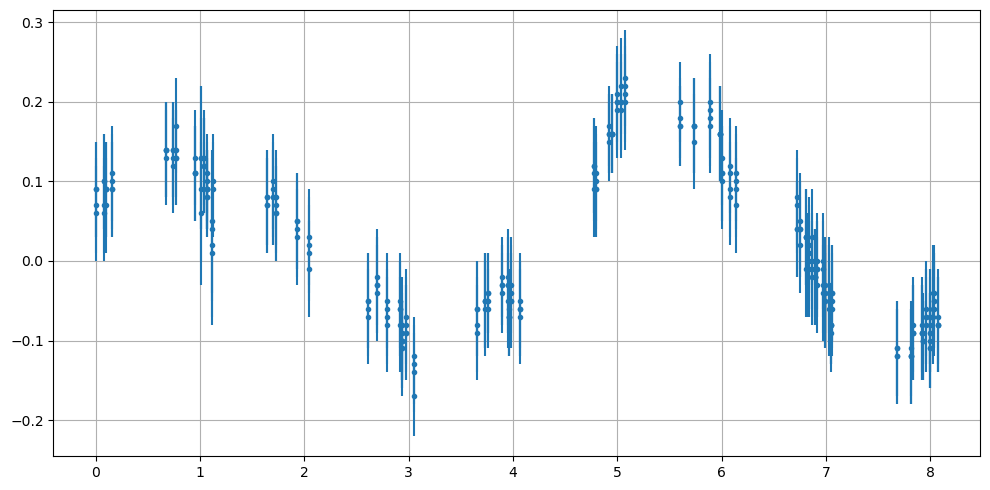

In [3]:
LCdata = pd.read_csv('AGNobsdata/graham2015data.csv')
LCdata['years'] = (LCdata.MJD.to_numpy())/365
lcTIME = LCdata.years.to_numpy()
lcFLUX = LCdata.Mag.to_numpy() - np.median(LCdata.Mag.to_numpy())
lcFLUXerr = LCdata.Magerr.to_numpy()

lcTIME, lcFLUX, lcFLUXerr = sort_arrays_together(lcTIME, lcFLUX, lcFLUXerr)
lcTIME = lcTIME -lcTIME[0]

plt.figure(figsize=[10,5])
plt.errorbar(lcTIME, lcFLUX, yerr=lcFLUXerr, fmt = '.')
plt.grid()
plt.tight_layout()
plt.show()

# JAXNS

In [5]:
import NSmodels_graham as NSgraham

In [5]:
modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)

DRW_NSmodel = modelCreater.create_model(NSgraham.DRW_generative_prior, NSgraham.DRW_log_likelihood_model)
#DRW_sine_NSmodel = modelCreater.create_model(NSgraham.DRW_sine_generative_prior, NSgraham.DRW_sine_log_likelihood_model)

# CARMA21_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(2,1, functype="prior"), 
#                                             create_CARMA_JAXNS_model_funcs(2,1, functype="likelihood"))
# CARMA21_sine_NSmodel = modelCreater.create_model(create_CARMAsine_JAXNS_model_funcs(2,1, functype='prior'),
#                                             create_CARMAsine_JAXNS_model_funcs(2,1, functype='likelihood'))
    
OBPL_10_NSmodel = modelCreater.create_model(NSgraham.OBPL_generative_prior, NSgraham.OBPL_log_likelihood_model, n_component = 10)
#OBPLsine_10_NSmodel = modelCreater.create_model(NSgraham.OBPLsine_generative_prior, NSgraham.OBPLsine_log_likelihood_model, n_component = 10)


print('generating posteriors for OBPL parameters for given data...', flush=True)
#blockPrint()
ModelCOMP = ModelComparison(lcTIME, lcFLUX, lcFLUXerr, verbose=True)
# ModelCOMP.add_NestedModel(OBPL_linear_10_NSmodel, 'OBPL10_linear')
# ModelCOMP.add_NestedModel(OBPLsine_linear_10_NSmodel, 'OBPL10sine_linear')

# ModelCOMP.add_NestedModel(DRW_linear_NSmodel, 'DRW_linear')
# ModelCOMP.add_NestedModel(DRW_linear_sine_NSmodel, 'DRWsine_linear')

ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL10')
#ModelCOMP.add_NestedModel(OBPLsine_10_NSmodel, 'OBPL10sine')

ModelCOMP.add_NestedModel(DRW_NSmodel, 'DRW')
#ModelCOMP.add_NestedModel(DRW_sine_NSmodel, 'DRWsine')

# ModelCOMP.add_NestedModel(CARMA21_NSmodel, 'CARMA21')
# ModelCOMP.add_NestedModel(CARMA21_sine_NSmodel, 'CARMA21sine')
ModelCOMP.run_NSsampler()
#enablePrint()
print('Posteriors generated...', flush=True)

generating posteriors for OBPL parameters for given data...


INFO[2024-10-08 10:41:29,004]: Number of parallel Markov-chains set to: 400


Model Comparion object created.
JAXNS model added.
JAXNS model added.
Total number of models being sampled :  2
--------------------------------------------------------------------------
Model being sampled :  OBPL10
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.


WARNING[2024-10-08 10:41:50,189]: live_evidence_frac is deprecated, use dlogZ instead.
WARNING[2024-10-08 10:54:18,163]: live_evidence_frac is deprecated, use dlogZ instead.


Sampling finished.
TerminationCondition :  Small remaining evidence




INFO[2024-10-08 10:54:20,652]: Number of parallel Markov-chains set to: 400


Model being sampled :  DRW
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.


WARNING[2024-10-08 10:54:29,195]: live_evidence_frac is deprecated, use dlogZ instead.
WARNING[2024-10-08 11:04:01,063]: live_evidence_frac is deprecated, use dlogZ instead.


Sampling finished.
TerminationCondition :  Small remaining evidence


Posteriors generated...


In [6]:
ModelCOMP.pretty_print()

+-----------------------+------------------------------+------------------------------+
|                       |            OBPL10            |             DRW              |
+-----------------------+------------------------------+------------------------------+
|  Number of Parameters |              5               |              3               |
| Termination condition | ['Small remaining evidence'] | ['Small remaining evidence'] |
|          logZ         |      742.8425562438473       |      744.1278925964448       |
|           H           |      -9.842994152891492      |      -5.754876557926082      |
|          ESS          |      1379.8691795260959      |      825.9780158376542       |
+-----------------------+------------------------------+------------------------------+


Model comparison results
+--------------+------------+
|              | DRW/OBPL10 |
+--------------+------------+
|    Z1/Z2     | 3.616e+00  |
| log10(Z1/Z2) |   0.5582   |
+--------------+------------+


In [7]:
import json
for i, val in enumerate(ModelCOMP.models()):
    model_dict = ModelCOMP.return_samples_logZ_dict(val)
    with open("tests/original_data_" + val+ ".json", "w") as outfile: 
        json.dump(model_dict, outfile)
    del model_dict

NameError: name 'json' is not defined

In [ ]:
OBPL10_dict = ModelCOMP.return_samples_logZ_dict('OBPL_10')
DRW_dict = ModelCOMP.return_samples_logZ_dict('DRW')

In [ ]:
import corner

def plot_corner(dictionary: dict, log_scale_keys: list = None, exclude_keys: list = ['log_Z_mean', 'log_Z_uncert']):
    """
    Create a corner plot from a dictionary of data arrays.

    Parameters:
    - dictionary (dict): Dictionary containing data arrays to plot.
    - log_scale_keys (list): Keys of the dictionary to apply log scale. Defaults to None.
    - exclude_keys (list): Keys to exclude from the plot. Defaults to ['log_Z_mean', 'log_Z_uncert'].

    Returns:
    - fig: The figure object containing the corner plot.
    - axes: The axes object for the subplots.
    """
    if exclude_keys is None:
        exclude_keys = []
    if log_scale_keys is None:
        log_scale_keys = []

    # Define the key renaming mapping
    key_mapping = {
        'A1': '$A_1$',
        'A2': '$A_2$',
        't0': '$T_{period}$',
        'scales': '$log_{10}(f_{bend})$',
        'amp': '$log_{10}(A)$',
        'err_scale': '$\\nu$',
        'alpha_l' : '$\\alpha_l$',
        'alpha_h' : '$\\alpha_h$'
    }

    # Filter the dictionary
    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    # Transform specified keys to log scale
    for key in log_scale_keys:
        if key in filtered_data:
            filtered_data[key] = np.log10(filtered_data[key])
            filtered_data[key] = np.where(filtered_data[key] == -np.inf, np.nan, filtered_data[key])  # Handle -inf values

    # Rename keys based on the mapping
    renamed_data = {key_mapping.get(key, key): value for key, value in filtered_data.items()}

    # Prepare the data for plotting
    data = np.array([array for array in renamed_data.values()]).T

    # Create the corner plot
    fig = corner.corner(data, bins=50, labels=list(renamed_data.keys()), show_titles=True, title_kwargs={"fontsize": 14}, label_kwargs={'fontsize':18})

    # Accessing each subplot individually
    axes = np.array(fig.axes).reshape((len(renamed_data), len(renamed_data)))

     # Calculate modes for each subplot
    modes = {}
    num_params = len(renamed_data)

    for i in range(num_params):
        for j in range(num_params):
            if i == j:
                # Diagonal subplots: mode of the histogram for the single parameter
                key = list(renamed_data.keys())[i]
                hist, bins = np.histogram(renamed_data[key], bins=50)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                peak_value = bin_centers[np.argmax(hist)]
                modes[(i, j)] = (peak_value, peak_value)  # Mode is the same for both x and y
            else:
                # Off-diagonal subplots: mode of the histogram for x and y directions
                x_peak = mode(data[:, j], nan_policy='omit').mode
                y_peak = mode(data[:, i], nan_policy='omit').mode
                modes[(i, j)] = (x_peak, y_peak)

            


    # Customize the plot to reflect log scaling in labels
    def log_formatter(val, pos):
        return r"$10^{{{:.0f}}}$".format(val)
    for i, key in enumerate(renamed_data.keys()):
        if key in [key_mapping.get(k, k) for k in log_scale_keys]:  # Check if renamed key is in log_scale_keys
            for j in range(len(renamed_data)):
                if i == j:
                    ax = axes[i, j]
                    #ax.set_title(f"log10({key})", fontsize=12)
                    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[-1, j].set_xlabel(f"{key}", fontsize=18)
                    axes[-1, j].xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[i, 0].set_ylabel(f"{key}", fontsize=18)
                    axes[i, 0].yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    
                    # Calculate and display percentiles
                    percentiles = np.percentile(renamed_data[key], [16, 50, 84])
                    if key == '$log_{10}(f_{bend})$':
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=12.5)    
                    else:
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=14)

    # for i in range(num_params):
    #     for j in range(num_params):
    #         if i>j:
    #             ax = axes[i, j]
    #             ax.axvline(modes[(i, j)][0])   
    #             ax.axhline(modes[(i, j)][1])           
    
    plt.show()
    return fig, axes


# MCMC

In [4]:
import emcee

In [5]:
def log_prior_DRW(log_theta):
    log_amp, log_scale, err_scale = log_theta

    # Log-normal prior for amp: LogNormal(mean=-4, stddev=1.15) -> on log scale
    log_amp_prior = - ((log_amp + 4)**2 / (2 * 1.15**2)) - np.log(1.15 * np.sqrt(2 * np.pi))

    # Log-normal prior for scale: LogNormal(mean=-0.6, stddev=1.15) -> on log scale
    log_scale_prior = - ((log_scale + 0.6)**2 / (2 * 1.15**2)) - np.log(1.15 * np.sqrt(2 * np.pi))

    # Uniform prior for err_scale: Uniform(0, 1.5) -> on log scale
    if 0 <= err_scale <= 1.5:
        log_err_scale_prior = 0.0  # Uniform prior is flat, so log-prior is constant
    else:
        return -np.inf  

    # Sum of all log-priors
    return log_amp_prior + log_scale_prior + log_err_scale_prior


def DRW_log_likelihood_model(log_theta, time, y, y_errs):
    
    log_amp, log_scale, err_scale = log_theta
    amp = np.exp(log_amp)
    scale = np.exp(log_scale)
    
    # Create kernel using the converted parameters
    kernel = amp * kernels.Exp(scale=scale)
    
    # Gaussian Process model (you may have a different GP implementation)
    gp = GaussianProcess(kernel, time, diag=(err_scale * y_errs)**2, mean=0)
    
    # Return the log-likelihood
    return gp.log_probability(y)


def log_probability_DRW(theta, x, y, yerr):
    lp = log_prior_DRW(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + DRW_log_likelihood_model(theta, x, y, yerr)

In [6]:
ndim = 3
nwalkers = 15  

initial = np.array([0.5, 0.5, 0.5])
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler_DRW = emcee.EnsembleSampler(nwalkers, ndim, log_probability_DRW, args=(lcTIME, lcFLUX, lcFLUXerr))
nsteps = 5000
_ = sampler_DRW.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 5000/5000 [13:50<00:00,  6.02it/s]


In [7]:
samples = sampler_DRW.get_chain()
flat_samples = sampler_DRW.get_chain(discard=0, thin=1, flat=True)

In [8]:
arr= {"log_amp":flat_samples.T[0], "log_scale":flat_samples.T[1], "err_scale":flat_samples.T[2]}
arr_log10 = {"log_amp":0.434294* flat_samples.T[0], "log_scale":0.434294* flat_samples.T[1], "err_scale":flat_samples.T[2]}

In [9]:
def plot_corner(dictionary: dict, log_scale_keys: list = None, exclude_keys: list = ['log_Z_mean', 'log_Z_uncert']):
    """
    Create a corner plot from a dictionary of data arrays.

    Parameters:
    - dictionary (dict): Dictionary containing data arrays to plot.
    - log_scale_keys (list): Keys of the dictionary to apply log scale. Defaults to None.
    - exclude_keys (list): Keys to exclude from the plot. Defaults to ['log_Z_mean', 'log_Z_uncert'].

    Returns:
    - fig: The figure object containing the corner plot.
    - axes: The axes object for the subplots.
    """
    if exclude_keys is None:
        exclude_keys = []
    if log_scale_keys is None:
        log_scale_keys = []

    # Define the key renaming mapping
    key_mapping = {
        'A1': '$A_1$',
        'A2': '$A_2$',
        't0': '$T_{period}$',
        'scales': '$log_{10}(f_{bend})$',
        'amp': '$log_{10}(A)$',
        'err_scale': '$\\nu$',
        'alpha_l' : '$\\alpha_l$',
        'alpha_h' : '$\\alpha_h$',
        'log_scale': '$log_{10}(f_{bend})$',
        'log_amp': '$log_{10}(A)$',
    }

    # Filter the dictionary
    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    # Transform specified keys to log scale
    for key in log_scale_keys:
        if key in filtered_data:
            filtered_data[key] = np.log10(filtered_data[key])
            filtered_data[key] = np.where(filtered_data[key] == -np.inf, np.nan, filtered_data[key])  # Handle -inf values

    # Rename keys based on the mapping
    renamed_data = {key_mapping.get(key, key): value for key, value in filtered_data.items()}

    # Prepare the data for plotting
    data = np.array([array for array in renamed_data.values()]).T

    # Create the corner plot
    fig = corner.corner(data, bins=100, labels=list(renamed_data.keys()), show_titles=True, title_kwargs={"fontsize": 14}, label_kwargs={'fontsize':18})

    # Accessing each subplot individually
    axes = np.array(fig.axes).reshape((len(renamed_data), len(renamed_data)))

     # Calculate modes for each subplot
    modes = {}
    num_params = len(renamed_data)

    for i in range(num_params):
        for j in range(num_params):
            if i == j:
                # Diagonal subplots: mode of the histogram for the single parameter
                key = list(renamed_data.keys())[i]
                hist, bins = np.histogram(renamed_data[key], bins=50)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                peak_value = bin_centers[np.argmax(hist)]
                modes[(i, j)] = (peak_value, peak_value)  # Mode is the same for both x and y
            else:
                # Off-diagonal subplots: mode of the histogram for x and y directions
                x_peak = mode(data[:, j], nan_policy='omit').mode
                y_peak = mode(data[:, i], nan_policy='omit').mode
                modes[(i, j)] = (x_peak, y_peak)

            


    # Customize the plot to reflect log scaling in labels
    def log_formatter(val, pos):
        return r"$10^{{{:.0f}}}$".format(val)
    for i, key in enumerate(renamed_data.keys()):
        if key in [key_mapping.get(k, k) for k in log_scale_keys]:  # Check if renamed key is in log_scale_keys
            for j in range(len(renamed_data)):
                if i == j:
                    ax = axes[i, j]
                    #ax.set_title(f"log10({key})", fontsize=12)
                    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[-1, j].set_xlabel(f"{key}", fontsize=18)
                    axes[-1, j].xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[i, 0].set_ylabel(f"{key}", fontsize=18)
                    axes[i, 0].yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    
                    # Calculate and display percentiles
                    percentiles = np.percentile(renamed_data[key], [16, 50, 84])
                    if key == '$log_{10}(f_{bend})$':
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=12.5)    
                    else:
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=14)


    plt.show()
    return fig, axes

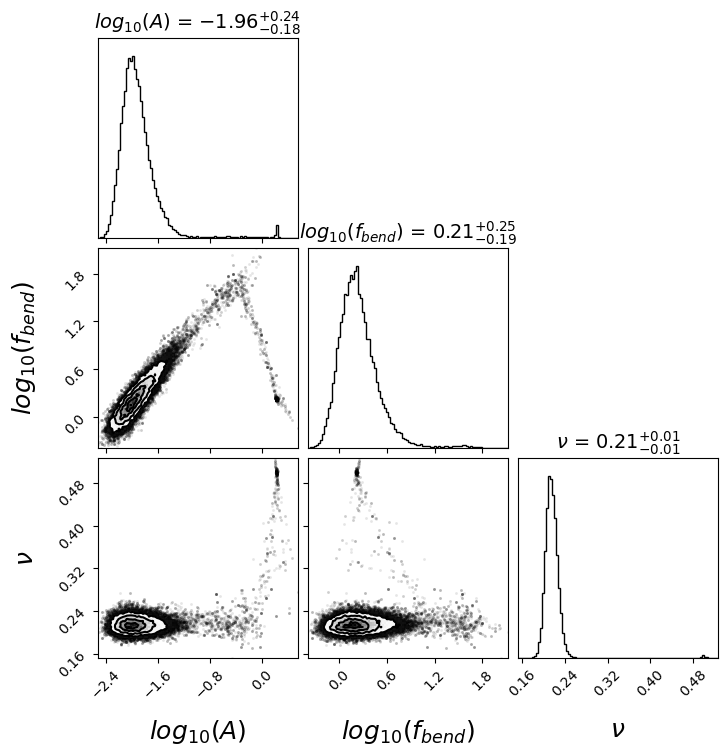

In [10]:
_ = plot_corner(arr_log10)

In [11]:
from pioran import PSDToACV
from pioran.psd import OneBendPowerLaw

In [12]:
def log_prior_OBPL(theta):
    alpha_l, alpha_h, log_scale, log_amp, err_scale = theta

    # alpha_l follows Uniform(-0.25, 2)
    if (-0.25 <= alpha_l <= 2):
        alpha_l_prior = 0.0
    else:
        return -np.inf

    # alpha_h follows Uniform(alpha_l, 4)
    if (alpha_l <= alpha_h <= 4):
        alpha_h_prior = 0.0
    else:
        return -np.inf
    
    # Log-normal prior for amp: LogNormal(mean=-4, stddev=1.15) -> on log scale
    log_amp_prior = - ((log_amp + 4)**2 / (2 * 1.15**2)) - np.log(1.15 * np.sqrt(2 * np.pi))

    # Log-normal prior for scale: LogNormal(mean=-0.6, stddev=1.15) -> on log scale
    log_scale_prior = - ((log_scale + 0.6)**2 / (2 * 1.15**2)) - np.log(1.15 * np.sqrt(2 * np.pi))

    # Uniform prior for err_scale: Uniform(0, 1.5) -> on log scale
    if 0 <= err_scale <= 1.5:
        err_scale_prior = 0.0  # Uniform prior is flat, so log-prior is constant
    else:
        return -np.inf  

    # Sum of all log-priors
    return log_amp_prior + log_scale_prior + err_scale_prior + alpha_l_prior + alpha_h_prior


def OBPL_log_likelihood_model(theta, time, y, y_errs ):

    alpha_l, alpha_h, log_scale, log_amp, err_scale = theta
    amp = np.exp(log_amp)
    scale = np.exp(log_scale)
    
    psd = OneBendPowerLaw([amp, alpha_l, 1/scale, alpha_h], free_parameters=[True]*4)
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=time[-1] - time[0],
                dt=np.min(np.diff(time)),
                method='SHO',
                n_components=10,
                estimate_variance=True,
                init_variance=jnp.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF
    
    
    
    gp = GaussianProcess(kernel, time, diag=(y_errs*err_scale)**2, mean=0)
    
    return gp.log_probability(y)


def log_probability_OBPL(theta, x, y, yerr):
    lp = log_prior_OBPL(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + OBPL_log_likelihood_model(theta, x, y, yerr)

In [16]:
ndim = 5
nwalkers = 20  

initial = np.array([0.5, 2, 0.5, 0.5, 0.5])
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler_OBPL = emcee.EnsembleSampler(nwalkers, ndim, log_probability_OBPL, args=(lcTIME, lcFLUX, lcFLUXerr))
nsteps = 500
_ = sampler_OBPL.run_mcmc(p0, nsteps, progress=True)

  1%|          | 6/500 [03:08<4:18:38, 31.41s/it]Traceback (most recent call last):
  File "/home/vputhusser/miniconda3/envs/tester/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3627398/1072723290.py", line 63, in log_probability_OBPL
    return lp + OBPL_log_likelihood_model(theta, x, y, yerr)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3627398/1072723290.py", line 54, in OBPL_log_likelihood_model
    gp = GaussianProcess(kernel, time, diag=(y_errs*err_scale)**2, mean=0)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vputhusser/miniconda3/envs/tester/lib/python3.12/site-packages/equinox/_module.py", line 572, in __call__
    self = super(_ModuleMeta, initable_cls).__call__(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

emcee: Exception while calling your likelihood function:
  params: [0.50081527 2.00004668 0.49969993 0.4999398  0.50048972]
  args: (array([0.00000000e+00, 2.05753425e-05, 4.09589041e-05, 6.13698630e-05,
       7.94283288e-02, 7.94535068e-02, 7.94787397e-02, 7.95035890e-02,
       9.86707945e-02, 9.86900000e-02, 9.87092329e-02, 9.87285753e-02,
       1.61520575e-01, 1.61542658e-01, 1.61564712e-01, 1.61586822e-01,
       6.77473370e-01, 6.77489644e-01, 6.77505863e-01, 6.77522082e-01,
       7.37858795e-01, 7.37876274e-01, 7.37894274e-01, 7.37911973e-01,
       7.67864712e-01, 7.67883918e-01, 7.67903123e-01, 7.67922411e-01,
       9.56502630e-01, 9.56521945e-01, 9.56541151e-01, 9.56560329e-01,
       1.00580252e+00, 1.00580455e+00, 1.00580693e+00, 1.00580899e+00,
       1.03844584e+00, 1.03846690e+00, 1.03848792e+00, 1.03850888e+00,
       1.06842551e+00, 1.06844523e+00, 1.06846482e+00, 1.06848455e+00,
       1.07112329e+00, 1.07114189e+00, 1.07116016e+00, 1.07117868e+00,
       1.115148

KeyboardInterrupt: 